In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
Crema = r"C:\Users\KIIT\Desktop\mini\CREMA-D\AudioWAV"

In [3]:
import os
import pandas as pd

Crema = r"C:\Users\KIIT\Desktop\mini\CREMA-D\AudioWAV"

# List all files in the directory
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(os.path.join(Crema, file))
    # storing file emotions
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# Create dataframes
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate emotion and path dataframes
Crema_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows
print(Crema_df.head())


  Emotions                                               Path
0    angry  C:\Users\KIIT\Desktop\mini\CREMA-D\AudioWAV\10...
1  disgust  C:\Users\KIIT\Desktop\mini\CREMA-D\AudioWAV\10...
2     fear  C:\Users\KIIT\Desktop\mini\CREMA-D\AudioWAV\10...
3    happy  C:\Users\KIIT\Desktop\mini\CREMA-D\AudioWAV\10...
4  neutral  C:\Users\KIIT\Desktop\mini\CREMA-D\AudioWAV\10...


In [4]:
# Assign Crema_df to data_path
data_path = Crema_df

# Save data_path to a CSV file
data_path.to_csv("data_path.csv", index=False)

# Display the first few rows of data_path
print(data_path.head())

  Emotions                                               Path
0    angry  C:\Users\KIIT\Desktop\mini\CREMA-D\AudioWAV\10...
1  disgust  C:\Users\KIIT\Desktop\mini\CREMA-D\AudioWAV\10...
2     fear  C:\Users\KIIT\Desktop\mini\CREMA-D\AudioWAV\10...
3    happy  C:\Users\KIIT\Desktop\mini\CREMA-D\AudioWAV\10...
4  neutral  C:\Users\KIIT\Desktop\mini\CREMA-D\AudioWAV\10...


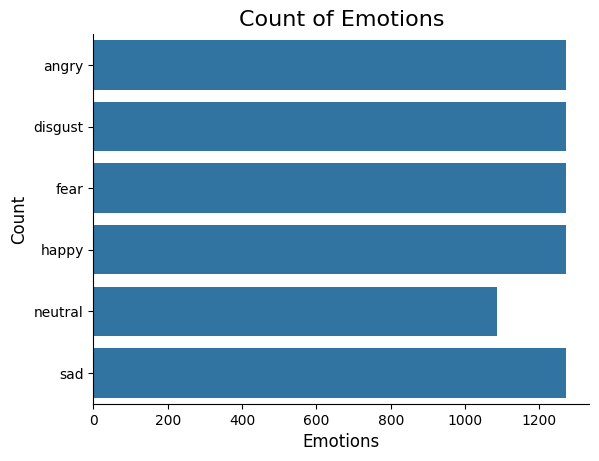

In [5]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [6]:
def create_waveplot(data, sr, e):
    """
    Create and display a waveplot for the given audio data.
    
    Parameters:
    data (numpy.ndarray): Audio time-series data.
    sr (int): Sampling rate of the audio data.
    e (str): Emotion label for the audio data.
    """
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    """
    Create and display a spectrogram for the given audio data.
    
    Parameters:
    data (numpy.ndarray): Audio time-series data.
    sr (int): Sampling rate of the audio data.
    e (str): Emotion label for the audio data.
    """
    # Convert the data into a short-term Fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    # To use logarithmic scale for frequency, uncomment the line below:
    # librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.show()


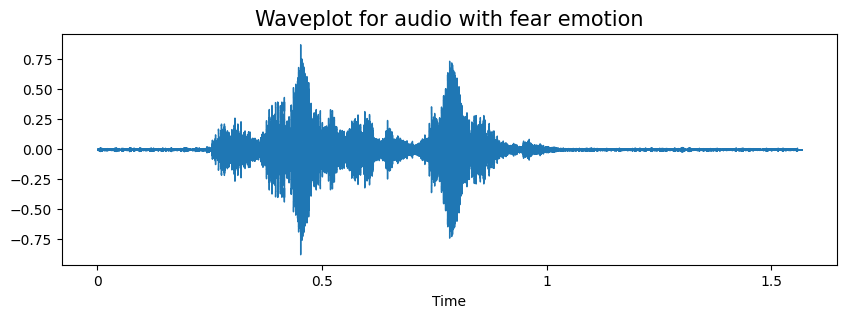

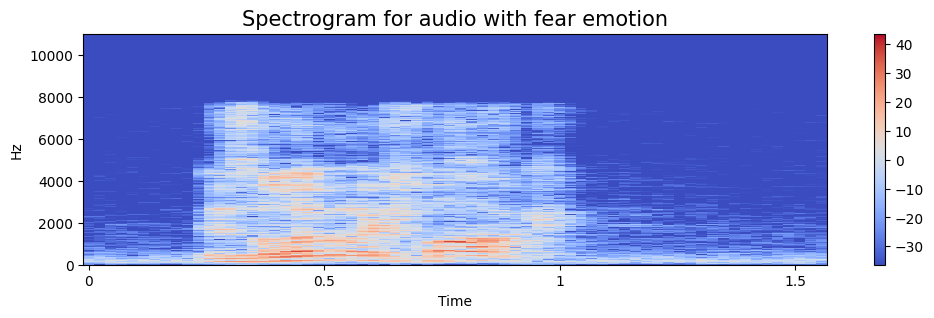

In [7]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

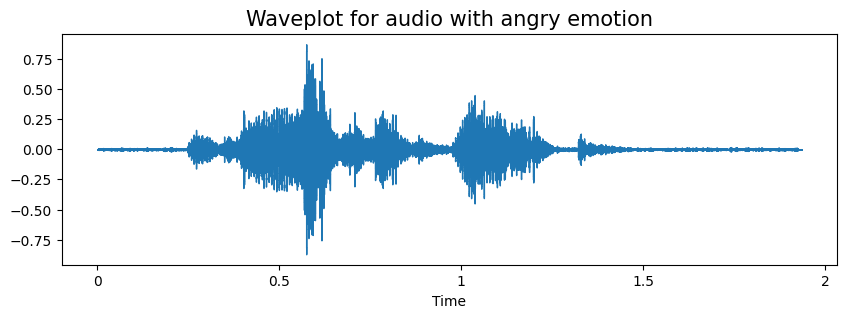

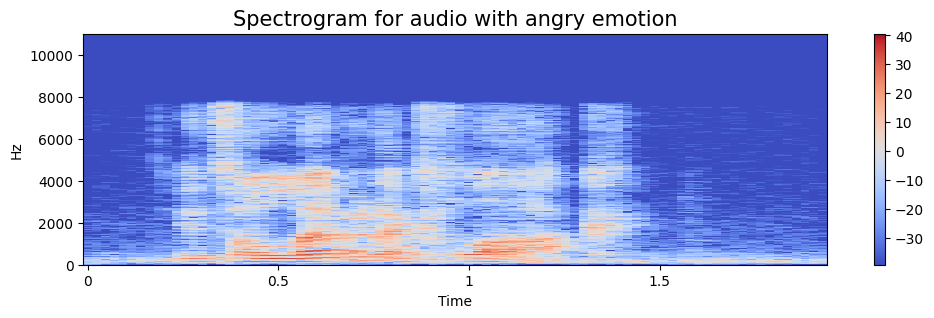

In [8]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

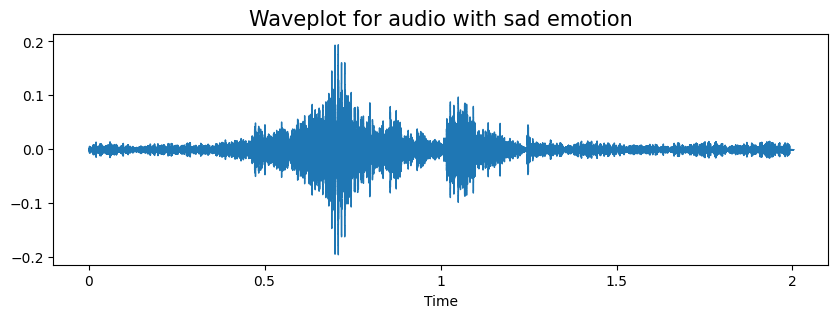

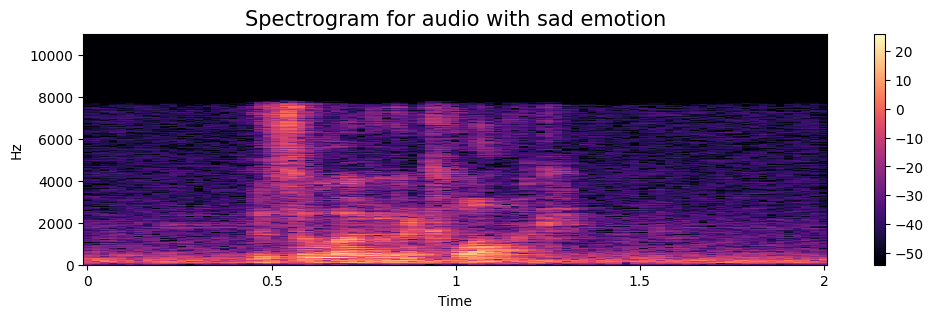

In [9]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

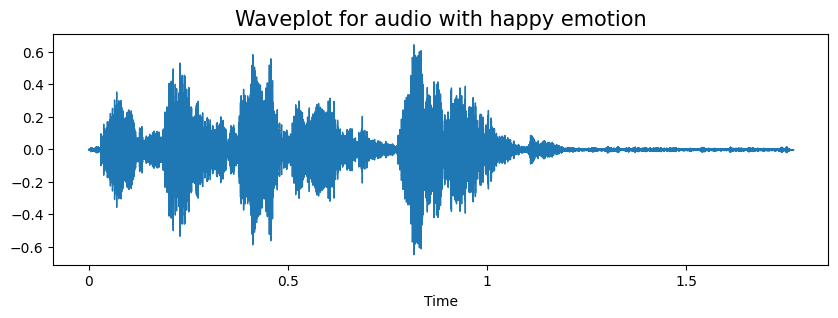

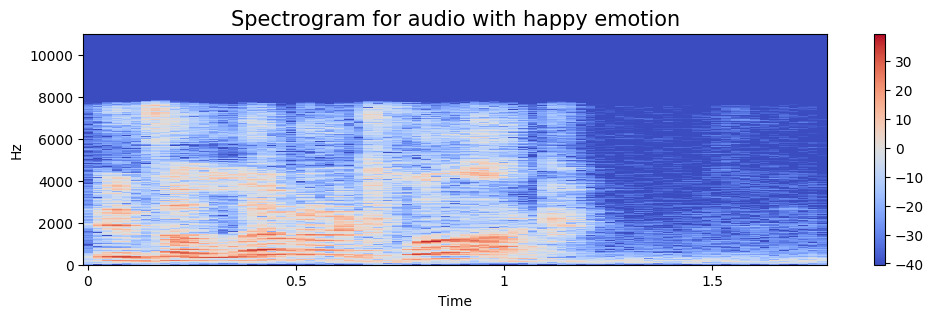

In [10]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)
    #return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

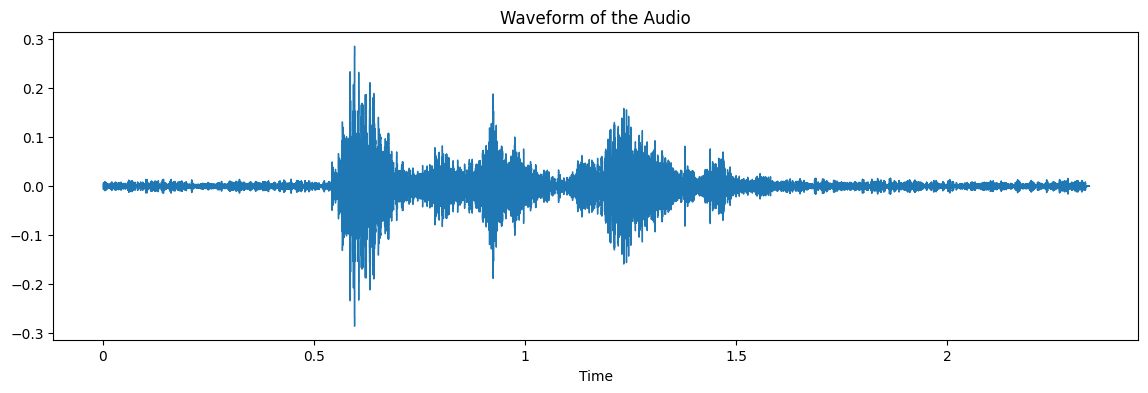

In [12]:
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Plot the waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(data, sr=sample_rate)
plt.title("Waveform of the Audio")
plt.show()

# Play the audio
Audio(path)

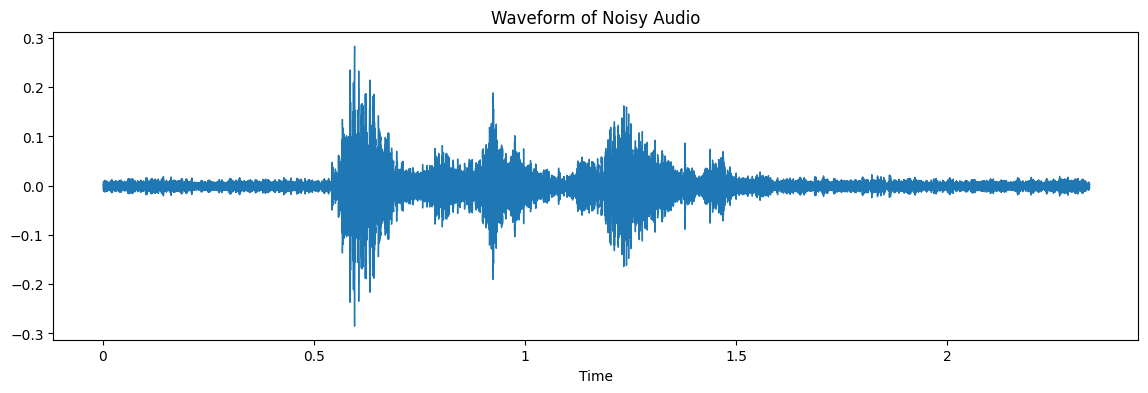

In [13]:
# Add noise to the audio
x = noise(data)

# Plot the waveform of the noisy audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(x, sr=sample_rate)
plt.title("Waveform of Noisy Audio")
plt.show()

# Play the noisy audio
Audio(x, rate=sample_rate)


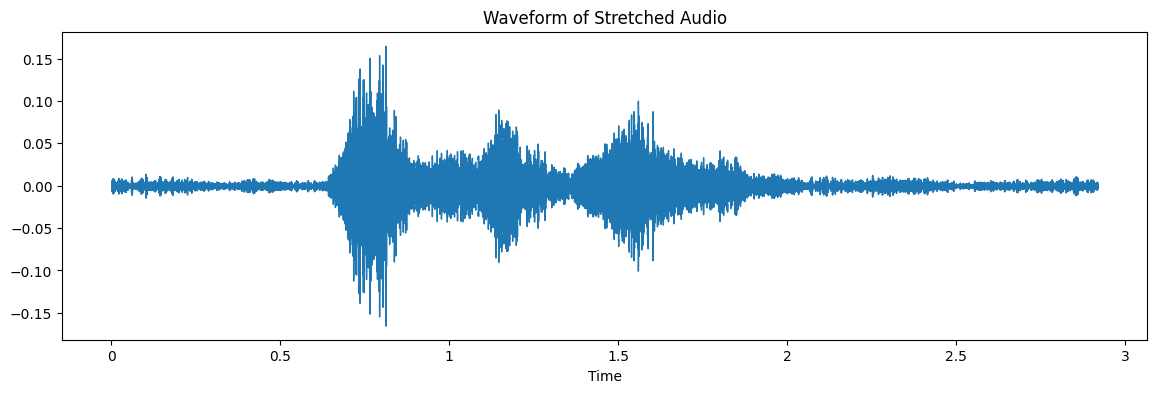

In [14]:
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Apply time stretching to the audio
x = librosa.effects.time_stretch(data, rate=0.8)

# Plot the waveform of the stretched audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(x, sr=sample_rate)
plt.title("Waveform of Stretched Audio")
plt.show()

# Play the stretched audio
Audio(x, rate=sample_rate)


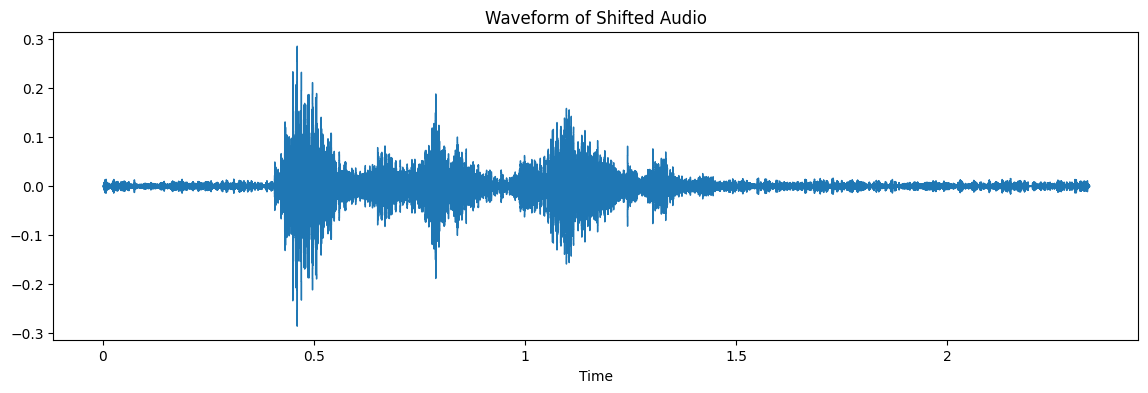

In [15]:
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Apply shifting to the audio
x = shift(data)

# Plot the waveform of the shifted audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(x, sr=sample_rate)
plt.title("Waveform of Shifted Audio")
plt.show()

# Play the shifted audio
Audio(x, rate=sample_rate)

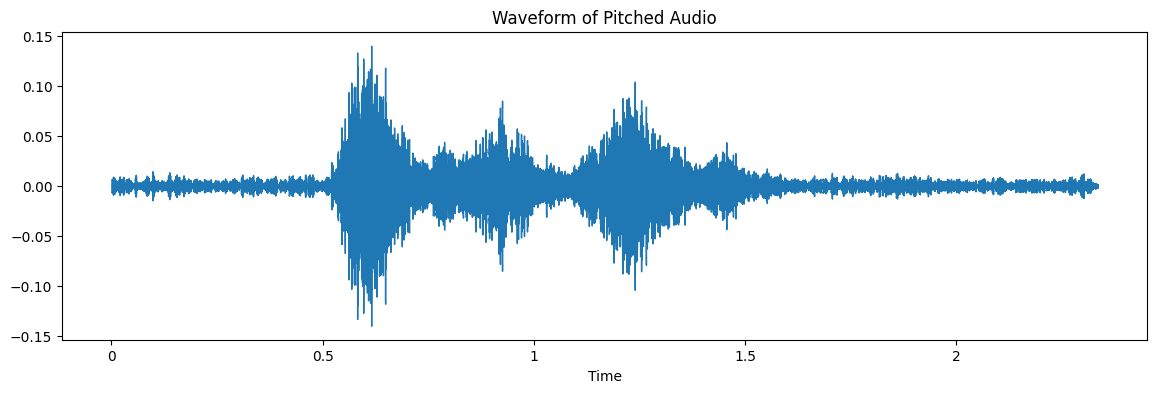

In [16]:
# Apply pitch shifting to the audio
x = pitch(data, sample_rate)

# Plot the waveform of the pitched audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(x, sr=sample_rate)
plt.title("Waveform of Pitched Audio")
plt.show()

# Play the pitched audio
Audio(x, rate=sample_rate)


In [17]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [18]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [19]:
len(X), len(Y), data_path.Path.shape

(22326, 22326, (7442,))

In [20]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.085690,0.671934,0.694386,0.672386,0.675259,0.674322,0.579565,0.578604,0.647424,0.650719,...,6.261535e-08,5.799611e-08,5.473501e-08,5.232019e-08,5.053353e-08,4.925763e-08,4.833769e-08,4.774562e-08,4.738036e-08,angry
1,0.294915,0.770199,0.788466,0.799468,0.824053,0.782174,0.652121,0.664277,0.727168,0.720051,...,6.876659e-03,6.611521e-03,6.515323e-03,7.296272e-03,6.485132e-03,6.870510e-03,6.981708e-03,6.536350e-03,6.645664e-03,angry
2,0.093428,0.636515,0.615982,0.635541,0.683582,0.709473,0.584347,0.544490,0.627884,0.614110,...,5.421565e-08,4.762177e-08,4.319623e-08,3.999700e-08,3.765626e-08,3.605933e-08,3.509663e-08,2.803464e-08,1.090318e-08,angry
3,0.078444,0.718596,0.729192,0.653268,0.665332,0.687527,0.602966,0.577669,0.618406,0.681478,...,4.336244e-07,4.003989e-07,3.764672e-07,3.584461e-07,3.449016e-07,3.350527e-07,3.278495e-07,3.231356e-07,3.202182e-07,disgust
4,0.219023,0.809880,0.799908,0.777087,0.801694,0.819908,0.693136,0.641626,0.691965,0.724803,...,1.360376e-03,1.251022e-03,1.235523e-03,1.302621e-03,1.266541e-03,1.276041e-03,1.295653e-03,1.279581e-03,1.289422e-03,disgust


In [21]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [22]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [23]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162), (16744, 6), (5582, 162), (5582, 6))

In [24]:
from sklearn.preprocessing import StandardScaler

# Scaling the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Checking the shapes
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((16744, 162), (16744, 6), (5582, 162), (5582, 6))

In [25]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 162, 1), (16744, 6), (5582, 162, 1), (5582, 6))

In [26]:
# model=Sequential()
# model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(Dropout(0.2))

# model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Flatten())
# model.add(Dense(units=32, activation='relu'))
# model.add(Dropout(0.3))

# model.add(Dense(units=6, activation='softmax'))
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# model.summary()
# 54%

# from keras.models import Sequential
# from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# model = Sequential()

# # Initial CNN Layers for feature extraction
# model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
# model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
# model.add(Dropout(0.2))

# # LSTM Layers for temporal modeling
# model.add(LSTM(128, return_sequences=True))  # First LSTM layer, outputs sequences
# model.add(LSTM(64, return_sequences=True))   # Second LSTM layer, outputs sequences
# model.add(LSTM(32, return_sequences=False))  # Final LSTM layer, outputs a single vector

# # Fully Connected Layers
# model.add(Dense(units=64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(units=6, activation='softmax'))

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()
#47.15%

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

model = Sequential()

# Single CNN Layer for initial feature extraction
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

# LSTM Layers for temporal modeling
model.add(LSTM(128, return_sequences=True))  # First LSTM layer
model.add(LSTM(128, return_sequences=True))  # Second LSTM layer
model.add(LSTM(64, return_sequences=True))   # Third LSTM layer
model.add(LSTM(32, return_sequences=False))  # Fourth LSTM layer

# Fully Connected Layers
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 162, 128)            │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 81, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 81, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 81, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 81, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 81, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 328,262 (1.25 MB)

 Trainable params: 328,262 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 56s 193ms/step - accuracy: 0.2847 - loss: 1.6514 - val_accuracy: 0.2771 - val_loss: 1.6043 - learning_rate: 0.0010
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 47s 181ms/step - accuracy: 0.3377 - loss: 1.5671 - val_accuracy: 0.3604 - val_loss: 1.5196 - learning_rate: 0.0010
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 52s 200ms/step - accuracy: 0.3595 - loss: 1.5361 - val_accuracy: 0.3726 - val_loss: 1.5106 - learning_rate: 0.0010
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 47s 178ms/step - accuracy: 0.3701 - loss: 1.5171 - val_accuracy: 0.3805 - val_loss: 1.5195 - learning_rate: 0.0010
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 47s 179ms/step - accuracy: 0.3742 - loss: 1.5116 - val_accuracy: 0.3766 - val_loss: 1.4916 - learning_rate: 0.0010
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 49s 188ms/step - accuracy: 0.3700 - loss: 1.5008 - val_accuracy: 0.3836 - val_loss: 1.4853 - learning_rate: 0.0010
Epoch 7/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 51s 195ms/step - accuracy: 0.3

175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4786 - loss: 1.3913
Accuracy of our model on test data :  46.95449769496918 %


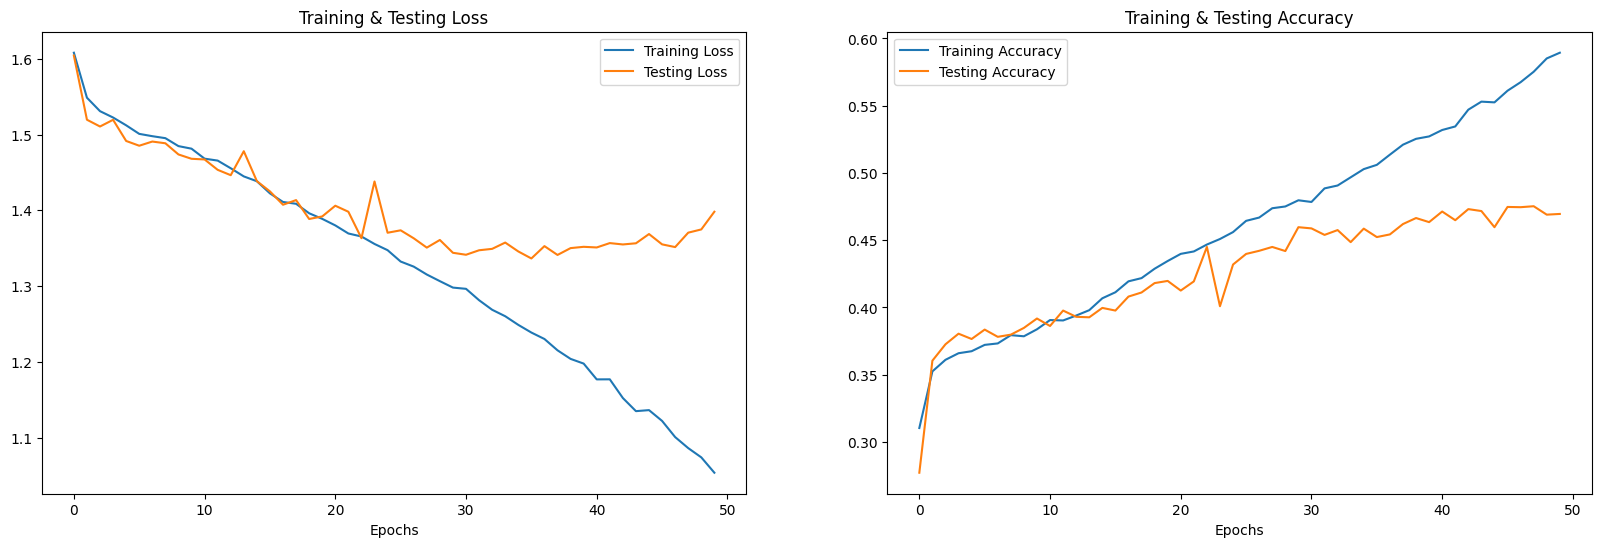

In [28]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [29]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step


In [30]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,fear
1,happy,happy
2,sad,sad
3,neutral,neutral
4,disgust,disgust
5,neutral,neutral
6,angry,angry
7,sad,sad
8,happy,neutral
9,happy,sad


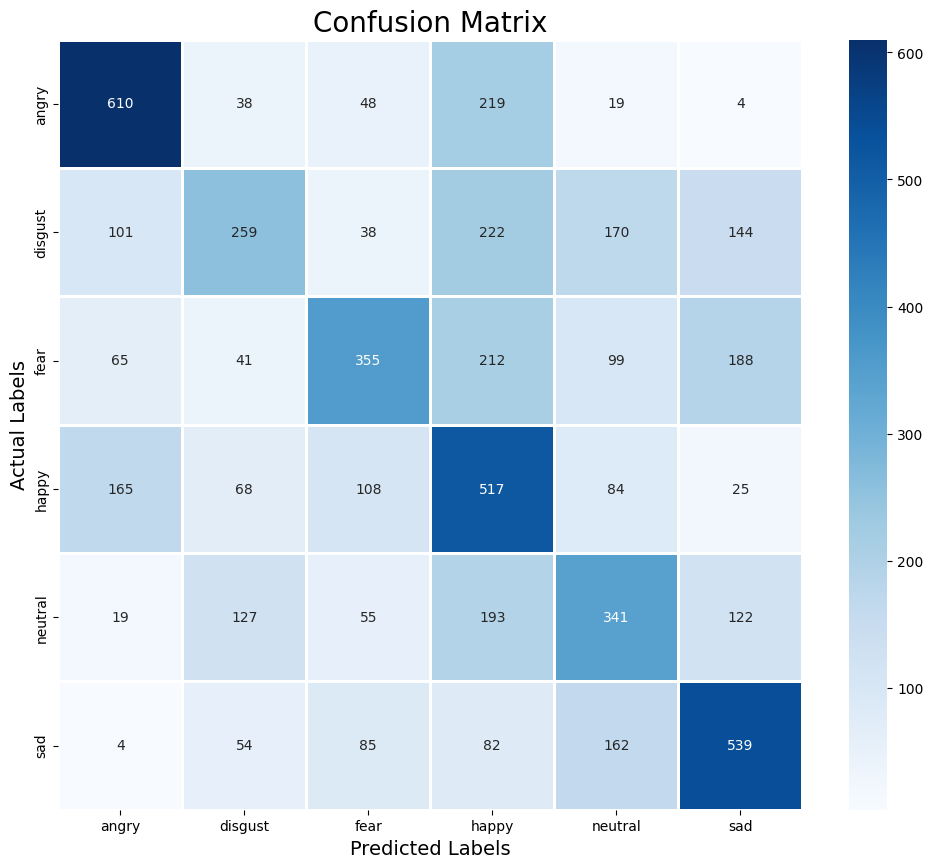

In [31]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()